<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/Progressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [ ]:
cp /content/drive/My\ Drive/CheXpert-v1.0-small.zip .

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

In [ ]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df = add_columns(full_train_df, False)

In [ ]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df = add_columns(full_valid_df, True)

In [ ]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [ ]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [ ]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [ ]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [ ]:
data = src.transform(tfms, size=160, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=224).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.74E-02


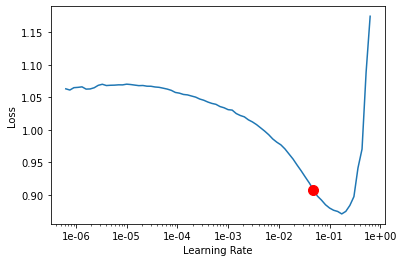

In [13]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 4e-2

In [13]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='avg_auc_metric')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.411688,0.494113,0.862800,34:15
1,0.413830,0.448448,0.877092,32:22
2,0.406215,0.461659,0.880548,32:45
3,0.401634,0.502621,0.880560,32:32
4,0.393472,0.456900,0.882534,33:05
5,0.388908,0.429421,0.880053,33:30
6,0.380341,0.430459,0.876548,33:48
7,0.379005,0.437724,0.871350,33:48


Better model found at epoch 0 with avg_auc_metric value: 0.8628002591873368.
Better model found at epoch 1 with avg_auc_metric value: 0.8770917029225788.
Better model found at epoch 2 with avg_auc_metric value: 0.88054847526358.
Better model found at epoch 3 with avg_auc_metric value: 0.8805600805820655.
Better model found at epoch 4 with avg_auc_metric value: 0.8825344471308408.


In [ ]:
learn.unfreeze()

Min numerical gradient: 3.02E-05
Min loss divided by 10: 9.12E-06


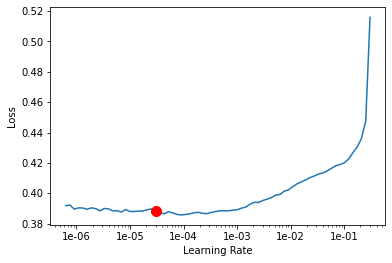

In [30]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(6, slice(3e-5, lr/10), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='avg_auc_metric', name='unfreeze160')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.388748,0.428049,0.875215,35:23
1,0.389318,0.426862,0.872236,34:09
2,0.381893,0.447940,0.872603,33:56
3,0.376068,0.438199,0.879741,37:06
4,0.368433,0.437952,0.875741,34:54
5,0.368017,0.431020,0.881101,34:39


Better model found at epoch 0 with avg_auc_metric value: 0.8752147018826738.
Better model found at epoch 3 with avg_auc_metric value: 0.8797409765678942.
Better model found at epoch 5 with avg_auc_metric value: 0.8811012029531187.


In [ ]:
learn.load('unfreeze160')
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.806	 chexpert auc: 0.858	 difference:    0.0519
Cardiomegaly    	 auc: 0.806	 chexpert auc: 0.854	 difference:    0.0481
Consolidation   	 auc: 0.92	 chexpert auc: 0.939	 difference:    0.0192
Edema           	 auc: 0.928	 chexpert auc: 0.941	 difference:    0.0129
Pleural Effusion	 auc: 0.932	 chexpert auc: 0.936	 difference:    0.00436

Average auc: 0.878 	 CheXpert average auc 0.906	 Difference 0.0273


In [ ]:
learn.load('bestmodel')

In [ ]:
validation_eval(learn, full_valid_df)

234 234
Atelectasis     	 auc: 0.802	 chexpert auc: 0.858	 difference:    0.0563
Cardiomegaly    	 auc: 0.838	 chexpert auc: 0.854	 difference:    0.0157
Consolidation   	 auc: 0.906	 chexpert auc: 0.939	 difference:    0.0326
Edema           	 auc: 0.915	 chexpert auc: 0.941	 difference:    0.0258
Pleural Effusion	 auc: 0.929	 chexpert auc: 0.936	 difference:    0.00689

Average auc: 0.878 	 CheXpert average auc 0.906	 Difference 0.0275


In [ ]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=56).normalize(imagenet_stats)

In [ ]:
learn.data = data

In [ ]:
data.train_ds[0][0].shape

torch.Size([3, 320, 320])

In [ ]:
learn.freeze()

In [ ]:
learn.summary()

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.92E-03


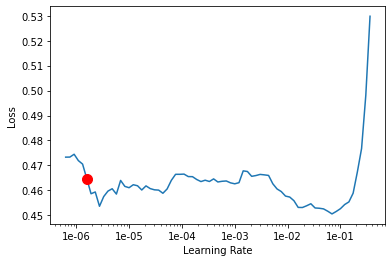

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 4e-3

In [ ]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', monitor='avg_auc_metric', name='freeze320')])

epoch,train_loss,valid_loss,avg_auc_metric,time
0,0.397163,0.428299,0.869741,1:02:47
1,0.391983,0.418477,0.882502,1:03:17
2,0.385835,0.437431,0.872299,1:03:41
3,0.385852,0.438914,0.871144,1:04:06
4,0.380610,0.426833,0.879874,1:04:00


In [ ]:
import shutil
shutil.make_archive('models', 'zip', 'models')
from google.colab import files
files.download('models.zip') 